In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
plt.rc('font', family="serif")
plt.rc('font', size=22)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac


In [3]:
from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
import os
import h5py


In [4]:
from diffstar.utils import _get_dt_array
from diffstar.fit_smah_helpers import get_header, load_diffstar_data
from diffstar.stars import (
    calculate_sm_sfr_fstar_history_from_mah,
    compute_fstar,
    compute_fstar_vmap,
    _sfr_eff_plaw,
    TODAY,
    _get_bounded_sfr_params, 
    _get_unbounded_sfr_params,
    calculate_histories,
    calculate_histories_vmap,
    calculate_histories_batch,
    fstar_tools,
    FB
)

from diffstar.quenching import _get_bounded_q_params, _get_unbounded_q_params
from diffmah.individual_halo_assembly import _calc_halo_history




/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [251]:
from validsky.dsps_seds_from_diffstar import *
from astropy.cosmology import Planck15, z_at_value 
import astropy.units as u
from dsps import load_fsps_data
from diffstar.stars import _depletion_kernel
from diffstar.quenching import _quenching_kern, quenching_function
from diffstar.stars import TODAY


In [6]:
data_path = "/Users/alarcon/Documents/diffmah_data/"
dsps_data_path = "/Users/alarcon/Documents/dsps_data/"

dsps_data = load_fsps_data.load_fsps_testing_data(dsps_data_path)
# return filter_data, ssp_data, lgZsun_bin_mids, log_age_gyr

In [125]:
filters = ["u", "g", "r", "i", "z", "y"]
mean_lambda = np.sum(trans_filters*wave_filters,axis=1)/np.sum(trans_filters,axis=1)
median_lambda = np.median(wave_filters, axis=1)

lgZsun_bin_mids = dsps_data[2]
log_age_gyr = dsps_data[3]
ssp_wave = dsps_data[1]['wave']
ssp_flux = np.load(dsps_data_path+"ssp_spec_flux_lines.npy")
met_params = np.array([[0.0, 0.25],])
cosmo_params =  np.array([0.307, 1-0.307, -1.0, 0.0, 0.677])
wave_filters = np.array([dsps_data[0]['%s_filter_wave'%filt] for filt in filters])
trans_filters = np.array([dsps_data[0]['%s_filter_trans'%filt] for filt in filters])


redshift_01_age = Planck15.age(0.1).value
t_obs_arr = np.linspace(1.0, redshift_01_age, 100)
z_obs_arr = np.array([z_at_value(Planck15.age, x * u.Gyr) for x in t_obs_arr])
z_obs_arr_phot = np.array([0.1, 1.0])
t_obs_arr_phot = Planck15.age(z_obs_arr_phot).value

tarr = np.linspace(0.1, redshift_01_age, 100)
lgt = np.log10(tarr)
dt = _get_dt_array(tarr)




fstar_tdelay = 1.0
index_select, fstar_indx_high = fstar_tools(tarr, fstar_tdelay=fstar_tdelay)


In [124]:
np.median(wave_filters, axis=1)

array([ 3642.5,  4766.5,  6214.5,  7544.5,  8707.5, 10036.5],
      dtype=float32)

In [178]:
"""
mah_params = np.array([[1.13980355, 13.4872,  1.5   ,  3.5       ,  3.5   ,0.192337 ],])
u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.275    ,  -1.0,  -0.5 , -0.767132 , 0.0 )
u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv = 1.9 ,  0.50515  , -2.57042  , -1.39016

"""

#mah_params = np.array([[1.13980355, 12.0894    ,  0.340066  ,  3.5       ,  2.031     , 0.23634],])
mah_params = np.array([[1.13980355, 12.5    ,  0.340066  ,  3.5       ,  2.031     , 0.23634],])
#u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (11.9566   ,  0.117006 , -0.355304 , -0.767132 ,  9.42471 )
u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0 , -0.355304 , -0.767132 ,  9.42471 )
u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv = 1.9 ,  0.50515  , -2.57042  , -1.39016

# u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.275    ,  -3.5,  -5.0 , 5.0 , 10.0 )

u_ms_params = np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],])
u_q_params =  np.array([[u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv],])
dmhdt, log_mah = _calc_halo_history(lgt, *mah_params[0])

# obs_mags : ndarray of shape (n_gals, n_filters)

obs_mag = np.zeros((len(wave_filters), len(z_obs_arr)))
 
    
for i in range(len(t_obs_arr)):
    """
    obs_mag[:,i] = compute_diffstarpop_obsframe_mags(
        t_obs_arr[i], 
        z_obs_arr[i], 
        lgZsun_bin_mids, 
        log_age_gyr, 
        ssp_wave, 
        ssp_flux, 
        mah_params, 
        u_ms_params, 
        u_q_params, 
        met_params, 
        cosmo_params, 
        wave_filters, 
        trans_filters, 
        dust_params=None
    )[0]
    """
    obs_mag[:,i] = compute_diffstarpop_restframe_mags(
            t_obs_arr[i], 
            lgZsun_bin_mids,
            log_age_gyr,
            ssp_wave,
            ssp_flux,
            mah_params,
            u_ms_params,
            u_q_params,
            met_params,
            wave_filters,
            trans_filters,
            dust_params=None
        )[0]


obs_mag_phot = np.zeros((len(wave_filters), len(z_obs_arr_phot)))
for i in range(len(t_obs_arr_phot)):
    """
    obs_mag_phot[:,i] = compute_diffstarpop_obsframe_mags(
        t_obs_arr_phot[i], 
        z_obs_arr_phot[i], 
        lgZsun_bin_mids, 
        log_age_gyr, 
        ssp_wave, 
        ssp_flux, 
        mah_params, 
        u_ms_params, 
        u_q_params, 
        met_params, 
        cosmo_params, 
        wave_filters, 
        trans_filters, 
        dust_params=None
    )[0]
    """
    obs_mag_phot[:,i] = compute_diffstarpop_restframe_mags(
            t_obs_arr_phot[i], 
            lgZsun_bin_mids,
            log_age_gyr,
            ssp_wave,
            ssp_flux,
            mah_params,
            u_ms_params,
            u_q_params,
            met_params,
            wave_filters,
            trans_filters,
            dust_params=None
        )[0]
    
efficiency_M0 = np.linspace(10, 14, 100)
MS_efficiency_fit = _sfr_eff_plaw(efficiency_M0, *(_get_bounded_sfr_params(*u_ms_params[0])[:4]))

mstar, sfr, fstar = calculate_sm_sfr_fstar_history_from_mah(
    lgt, dt, dmhdt, log_mah,
    u_ms_params[0], u_q_params[0],
    index_select,
    fstar_indx_high,
    fstar_tdelay
)


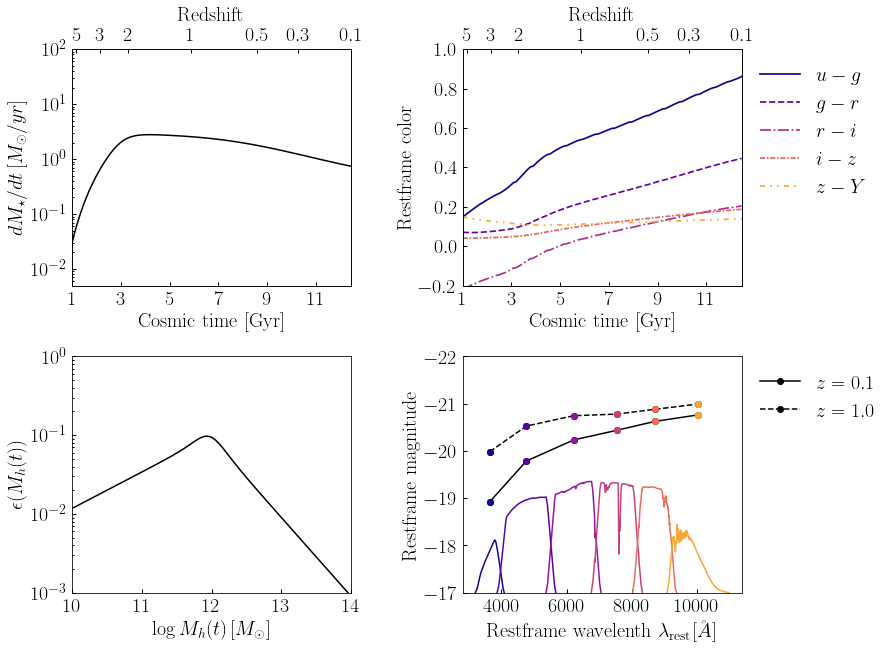

In [179]:
lsty = ['-', '--', '-.', (0, (3, 1, 1, 1)), (0, (3, 3, 1, 3, 1, 3))]
fontsize=20
colors = [
    'firebrick', 
    'lightseagreen', 
    'darkorange',
    mpurple,
]

fig, ax = plt.subplots(2,2, figsize=(12,10))


ax[0,0].plot(tarr, sfr, ls='-', color='k')

u_g = obs_mag[0] - obs_mag[1]
g_r = obs_mag[1] - obs_mag[2]
r_i = obs_mag[2] - obs_mag[3]
i_z = obs_mag[3] - obs_mag[4]
z_y = obs_mag[4] - obs_mag[5]


_colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 5))
lw = 1.7
ax[0,1].plot(t_obs_arr, u_g, ls=lsty[0], color=_colors[0], lw=lw, label=r"$u-g$")
ax[0,1].plot(t_obs_arr, g_r, ls=lsty[1], color=_colors[1], lw=lw, label=r"$g-r$")
ax[0,1].plot(t_obs_arr, r_i, ls=lsty[2], color=_colors[2], lw=lw, label=r"$r-i$")
ax[0,1].plot(t_obs_arr, i_z, ls=lsty[3], color=_colors[3], lw=lw, label=r"$i-z$")
ax[0,1].plot(t_obs_arr, z_y, ls=lsty[4], color=_colors[4], lw=lw, label=r"$z-Y$")

ax[0,1].legend(loc=2, bbox_to_anchor=(1.,1.), fontsize=fontsize)


ax[1,0].plot(efficiency_M0, MS_efficiency_fit, ls='-', color='k')


ax[1,1].plot(median_lambda, obs_mag_phot[:,0], marker='o', ls='-', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[0])    
ax[1,1].plot(median_lambda, obs_mag_phot[:,1], marker='o', ls='--', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[1])
ax[1,1].legend(loc=0, fontsize=fontsize, bbox_to_anchor=(1.,1.))
ax[1,1].set_ylim(-22, -17)
ax[1,1].invert_yaxis()
ylim = ax[1,1].set_ylim()

_colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 6))
for i in range(6):
    ax[1,1].plot(wave_filters[i], ylim[0] + np.diff(ylim)*trans_filters[i], color=_colors[i])
    ax[1,1].plot(median_lambda[i], obs_mag_phot[i,0], marker='o', ls='none', color=_colors[i])
    ax[1,1].plot(median_lambda[i], obs_mag_phot[i,1], marker='o', ls='none', color=_colors[i])


ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
ax[0,0].set_ylabel('$dM_\star/dt \,[M_{\odot}/yr]$', fontsize=fontsize)
ax[0,0].set_ylim(5e-3,1e2)
ax[0,0].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
ax[0,0].set_xlim(1, redshift_01_age)

ax[0,1].set_xlim(1, redshift_01_age)
ax[0,1].set_ylim(-0.2, 1.0)
ax[0,1].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
ax[0,1].set_ylabel('Restframe color', fontsize=fontsize)
ax[0,1].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
ax[0,1].set_xlim(1, redshift_01_age)

ax[1,0].set_yscale('log')
ax[1,0].set_ylim(1e-3, 1e0)
ax[1,0].set_xlim(10, 14)
ax[1,0].set_xticks(np.arange(10,14.1,1.0))
ax[1,0].set_xlabel('$\log M_{h}(t) \, [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$\epsilon(M_{h}(t))$', fontsize=fontsize)


ax[1,1].set_xlabel(r'Restframe wavelenth $\lambda_{\rm rest}[\AA]$', fontsize=fontsize)
ax[1,1].set_ylabel('Restframe magnitude', fontsize=fontsize)


for axis in ax.flatten():
    for tick in axis.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in axis.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
        
xlim = ax[0,0].set_xlim()
ax2 = ax[0,0].twiny()
ax2.set_xlim(xlim[0], xlim[1])
ax2.plot([],[])

ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
ticks_t = np.array(Planck15.age(ticks_z))
_sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

ax2.set_xticks(ticks_t)
ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
ax2.set_xlabel(r'Redshift', fontsize=fontsize)
ax2.xaxis.set_label_coords(0.5, 1.12) 
######

xlim = ax[0,1].set_xlim()
ax2 = ax[0,1].twiny()
ax2.set_xlim(xlim[0], xlim[1])
ax2.plot([],[])

ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
ticks_t = np.array(Planck15.age(ticks_z))
_sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

ax2.set_xticks(ticks_t)
ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
ax2.set_xlabel(r'Redshift', fontsize=fontsize)
ax2.xaxis.set_label_coords(0.5, 1.12)


fig.subplots_adjust(hspace=0.3, wspace=0.4)

#plt.savefig("test_dsps_diffstar_color_hist.png", bbox_inches='tight', dpi=300)

plt.show()

# Make sequence of GIFs

## Main Sequence params

In [167]:
u_ms_params_list = []

for x in np.linspace(12.0, 11.5, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (x   ,  -1.0 , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(11.5, 12.5, 10):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (x   ,  -1.0 , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(12.5, 12.0, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (x   ,  -1.0 , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-1.0, -1.5, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  x , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-1.5, -0.5, 10):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  x , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.5, -1.0, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  x , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.355304, -1.0, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, x , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-1.0, 1.0, 10):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, x , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(1.0, -0.355304, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, x , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.767132, -0.767132 - 0.75, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, -0.355304, x ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.767132 - 0.75, -0.767132 + 0.75, 10):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, -0.355304, x ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.767132 + 0.75, -0.767132, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, -0.355304, x ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))



In [168]:
sfh_list = []
eff_list = []
alpha_vals = np.concatenate(([1.0,], np.linspace(0.01, 0.2, 10)[::-1]))
alpha_vals = np.logspace(-2, 0, 10)[::-1]
for id_iter in range(len(u_ms_params_list)):

    u_ms_params = u_ms_params_list[id_iter]

    obs_mag = np.zeros((len(wave_filters), len(z_obs_arr)))


    for i in range(len(t_obs_arr)):
        obs_mag[:,i] = compute_diffstarpop_restframe_mags(
                t_obs_arr[i], 
                lgZsun_bin_mids,
                log_age_gyr,
                ssp_wave,
                ssp_flux,
                mah_params,
                u_ms_params,
                u_q_params,
                met_params,
                wave_filters,
                trans_filters,
                dust_params=None
            )[0]


    obs_mag_phot = np.zeros((len(wave_filters), len(z_obs_arr_phot)))
    for i in range(len(t_obs_arr_phot)):
        obs_mag_phot[:,i] = compute_diffstarpop_restframe_mags(
                t_obs_arr_phot[i], 
                lgZsun_bin_mids,
                log_age_gyr,
                ssp_wave,
                ssp_flux,
                mah_params,
                u_ms_params,
                u_q_params,
                met_params,
                wave_filters,
                trans_filters,
                dust_params=None
            )[0]

    efficiency_M0 = np.linspace(10, 14, 100)
    MS_efficiency_fit = _sfr_eff_plaw(efficiency_M0, *(_get_bounded_sfr_params(*u_ms_params[0])[:4]))

    mstar, sfr, fstar = calculate_sm_sfr_fstar_history_from_mah(
        lgt, dt, dmhdt, log_mah,
        u_ms_params[0], u_q_params[0],
        index_select,
        fstar_indx_high,
        fstar_tdelay
    )
    
    sfh_list.append(sfr)
    eff_list.append(MS_efficiency_fit)
    
    counts = np.arange(-len(alpha_vals), -0)[::-1][:min(len(alpha_vals), len(sfh_list))]
    
    

    lsty = ['-', '--', '-.', (0, (3, 1, 1, 1)), (0, (3, 3, 1, 3, 1, 3))]
    fontsize=20
    colors = [
        'firebrick', 
        'lightseagreen', 
        'darkorange',
        mpurple,
    ]

    fig, ax = plt.subplots(2,2, figsize=(12,10))
    
    

    for id_sfh, count in enumerate(counts):
        ax[0,0].plot(tarr, sfh_list[count], ls='-', color='k', alpha=alpha_vals[id_sfh])
        ax[1,0].plot(efficiency_M0, eff_list[count], ls='-', color='k', alpha=alpha_vals[id_sfh])

    u_g = obs_mag[0] - obs_mag[1]
    g_r = obs_mag[1] - obs_mag[2]
    r_i = obs_mag[2] - obs_mag[3]
    i_z = obs_mag[3] - obs_mag[4]
    z_y = obs_mag[4] - obs_mag[5]


    _colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 5))
    lw = 1.7
    ax[0,1].plot(t_obs_arr, u_g, ls=lsty[0], color=_colors[0], lw=lw, label=r"$u-g$")
    ax[0,1].plot(t_obs_arr, g_r, ls=lsty[1], color=_colors[1], lw=lw, label=r"$g-r$")
    ax[0,1].plot(t_obs_arr, r_i, ls=lsty[2], color=_colors[2], lw=lw, label=r"$r-i$")
    ax[0,1].plot(t_obs_arr, i_z, ls=lsty[3], color=_colors[3], lw=lw, label=r"$i-z$")
    ax[0,1].plot(t_obs_arr, z_y, ls=lsty[4], color=_colors[4], lw=lw, label=r"$z-Y$")

    ax[0,1].legend(loc=2, bbox_to_anchor=(1.,1.), fontsize=fontsize)


    


    ax[1,1].plot(median_lambda, obs_mag_phot[:,0], marker='o', ls='-', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[0])    
    ax[1,1].plot(median_lambda, obs_mag_phot[:,1], marker='o', ls='--', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[1])
    ax[1,1].legend(loc=2, fontsize=fontsize, bbox_to_anchor=(1.,1.))
    ax[1,1].set_ylim(-22, -17)
    ax[1,1].invert_yaxis()
    ylim = ax[1,1].set_ylim()

    _colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 6))
    for i in range(6):
        ax[1,1].plot(wave_filters[i], ylim[0] + np.diff(ylim)*trans_filters[i], color=_colors[i])
        ax[1,1].plot(median_lambda[i], obs_mag_phot[i,0], marker='o', ls='none', color=_colors[i])
        ax[1,1].plot(median_lambda[i], obs_mag_phot[i,1], marker='o', ls='none', color=_colors[i])


    ax[0,0].set_yscale('log')
    ax[0,0].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,0].set_ylabel('$dM_\star/dt \,[M_{\odot}/yr]$', fontsize=fontsize)
    ax[0,0].set_ylim(5e-3,1e2)
    ax[0,0].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[0,0].set_xlim(1, redshift_01_age)

    ax[0,1].set_xlim(1, redshift_01_age)
    ax[0,1].set_ylim(-0.2, 1.0)
    ax[0,1].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,1].set_ylabel('Restframe color', fontsize=fontsize)
    ax[0,1].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[0,1].set_xlim(1, redshift_01_age)

    ax[1,0].set_yscale('log')
    ax[1,0].set_ylim(1e-3, 1e0)
    ax[1,0].set_xlim(10, 14)
    ax[1,0].set_xticks(np.arange(10,14.1,1.0))
    ax[1,0].set_xlabel('$\log M_{h}(t) \, [M_{\odot}]$', fontsize=fontsize)
    ax[1,0].set_ylabel('$\epsilon(M_{h}(t))$', fontsize=fontsize)


    ax[1,1].set_xlabel(r'Restframe wavelenth $\lambda_{\rm rest}[\AA]$', fontsize=fontsize)
    ax[1,1].set_ylabel('Restframe magnitude', fontsize=fontsize)


    for axis in ax.flatten():
        for tick in axis.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
        for tick in axis.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 

    xlim = ax[0,0].set_xlim()
    ax2 = ax[0,0].twiny()
    ax2.set_xlim(xlim[0], xlim[1])
    ax2.plot([],[])

    ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
    ticks_t = np.array(Planck15.age(ticks_z))
    _sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
    ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

    ax2.set_xticks(ticks_t)
    ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
    ax2.set_xlabel(r'Redshift', fontsize=fontsize)
    ax2.xaxis.set_label_coords(0.5, 1.12) 
    ######

    xlim = ax[0,1].set_xlim()
    ax2 = ax[0,1].twiny()
    ax2.set_xlim(xlim[0], xlim[1])
    ax2.plot([],[])

    ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
    ticks_t = np.array(Planck15.age(ticks_z))
    _sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
    ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

    ax2.set_xticks(ticks_t)
    ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
    ax2.set_xlabel(r'Redshift', fontsize=fontsize)
    ax2.xaxis.set_label_coords(0.5, 1.12)


    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    plt.savefig("plots_eff/plot%d.png"%id_iter, bbox_inches='tight', dpi=300)

    plt.clf()
    plt.close()

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on 

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on 

## Main Sequence params v2

In [182]:
u_ms_params_list = []

for x in np.linspace(12.0, 11.5, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (x   ,  -1.0 , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))
    
for x in np.linspace(-0.767132, -0.767132 - 0.75, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (11.5   ,  -1.0, -0.355304, x ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.767132 - 0.75, -0.767132 + 0.75, 10):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (11.5   ,  -1.0, -0.355304, x ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.767132 + 0.75, -0.767132, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (11.5   ,  -1.0, -0.355304, x ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))


for x in np.linspace(11.5, 12.5, 10):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (x   ,  -1.0 , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(12.5, 12.0, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (x   ,  -1.0 , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-1.0, -1.5, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  x , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-1.5, -0.5, 10):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  x , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.5, -1.0, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  x , -0.355304 , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-0.355304, -1.0, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, x , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(-1.0, 1.0, 10):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, x , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(1.0, -0.355304, 5):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0, x , -0.767132 ,  9.42471 )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))




In [183]:
sfh_list = []
eff_list = []
alpha_vals = np.concatenate(([1.0,], np.linspace(0.01, 0.2, 10)[::-1]))
alpha_vals = np.logspace(-2, 0, 10)[::-1]
for id_iter in range(len(u_ms_params_list)):

    u_ms_params = u_ms_params_list[id_iter]

    obs_mag = np.zeros((len(wave_filters), len(z_obs_arr)))


    for i in range(len(t_obs_arr)):
        obs_mag[:,i] = compute_diffstarpop_restframe_mags(
                t_obs_arr[i], 
                lgZsun_bin_mids,
                log_age_gyr,
                ssp_wave,
                ssp_flux,
                mah_params,
                u_ms_params,
                u_q_params,
                met_params,
                wave_filters,
                trans_filters,
                dust_params=None
            )[0]


    obs_mag_phot = np.zeros((len(wave_filters), len(z_obs_arr_phot)))
    for i in range(len(t_obs_arr_phot)):
        obs_mag_phot[:,i] = compute_diffstarpop_restframe_mags(
                t_obs_arr_phot[i], 
                lgZsun_bin_mids,
                log_age_gyr,
                ssp_wave,
                ssp_flux,
                mah_params,
                u_ms_params,
                u_q_params,
                met_params,
                wave_filters,
                trans_filters,
                dust_params=None
            )[0]

    efficiency_M0 = np.linspace(10, 14, 100)
    MS_efficiency_fit = _sfr_eff_plaw(efficiency_M0, *(_get_bounded_sfr_params(*u_ms_params[0])[:4]))

    mstar, sfr, fstar = calculate_sm_sfr_fstar_history_from_mah(
        lgt, dt, dmhdt, log_mah,
        u_ms_params[0], u_q_params[0],
        index_select,
        fstar_indx_high,
        fstar_tdelay
    )
    
    sfh_list.append(sfr)
    eff_list.append(MS_efficiency_fit)
    
    counts = np.arange(-len(alpha_vals), -0)[::-1][:min(len(alpha_vals), len(sfh_list))]
    
    

    lsty = ['-', '--', '-.', (0, (3, 1, 1, 1)), (0, (3, 3, 1, 3, 1, 3))]
    fontsize=20
    colors = [
        'firebrick', 
        'lightseagreen', 
        'darkorange',
        mpurple,
    ]

    fig, ax = plt.subplots(2,2, figsize=(12,10))
    
    

    for id_sfh, count in enumerate(counts):
        ax[0,0].plot(tarr, sfh_list[count], ls='-', color='k', alpha=alpha_vals[id_sfh])
        ax[1,0].plot(efficiency_M0, eff_list[count], ls='-', color='k', alpha=alpha_vals[id_sfh])

    u_g = obs_mag[0] - obs_mag[1]
    g_r = obs_mag[1] - obs_mag[2]
    r_i = obs_mag[2] - obs_mag[3]
    i_z = obs_mag[3] - obs_mag[4]
    z_y = obs_mag[4] - obs_mag[5]


    _colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 5))
    lw = 1.7
    ax[0,1].plot(t_obs_arr, u_g, ls=lsty[0], color=_colors[0], lw=lw, label=r"$u-g$")
    ax[0,1].plot(t_obs_arr, g_r, ls=lsty[1], color=_colors[1], lw=lw, label=r"$g-r$")
    ax[0,1].plot(t_obs_arr, r_i, ls=lsty[2], color=_colors[2], lw=lw, label=r"$r-i$")
    ax[0,1].plot(t_obs_arr, i_z, ls=lsty[3], color=_colors[3], lw=lw, label=r"$i-z$")
    ax[0,1].plot(t_obs_arr, z_y, ls=lsty[4], color=_colors[4], lw=lw, label=r"$z-Y$")

    ax[0,1].legend(loc=2, bbox_to_anchor=(1.,1.), fontsize=fontsize)


    


    ax[1,1].plot(median_lambda, obs_mag_phot[:,0], marker='o', ls='-', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[0])    
    ax[1,1].plot(median_lambda, obs_mag_phot[:,1], marker='o', ls='--', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[1])
    ax[1,1].legend(loc=2, fontsize=fontsize, bbox_to_anchor=(1.,1.))
    ax[1,1].set_ylim(-22, -17)
    ax[1,1].invert_yaxis()
    ylim = ax[1,1].set_ylim()

    _colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 6))
    for i in range(6):
        ax[1,1].plot(wave_filters[i], ylim[0] + np.diff(ylim)*trans_filters[i], color=_colors[i])
        ax[1,1].plot(median_lambda[i], obs_mag_phot[i,0], marker='o', ls='none', color=_colors[i])
        ax[1,1].plot(median_lambda[i], obs_mag_phot[i,1], marker='o', ls='none', color=_colors[i])


    ax[0,0].set_yscale('log')
    ax[0,0].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,0].set_ylabel('$dM_\star/dt \,[M_{\odot}/yr]$', fontsize=fontsize)
    ax[0,0].set_ylim(5e-3,1e2)
    ax[0,0].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[0,0].set_xlim(1, redshift_01_age)

    ax[0,1].set_xlim(1, redshift_01_age)
    ax[0,1].set_ylim(-0.2, 1.0)
    ax[0,1].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,1].set_ylabel('Restframe color', fontsize=fontsize)
    ax[0,1].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[0,1].set_xlim(1, redshift_01_age)

    ax[1,0].set_yscale('log')
    ax[1,0].set_ylim(1e-3, 1e0)
    ax[1,0].set_xlim(10, 14)
    ax[1,0].set_xticks(np.arange(10,14.1,1.0))
    ax[1,0].set_xlabel('$\log M_{h}(t) \, [M_{\odot}]$', fontsize=fontsize)
    ax[1,0].set_ylabel('$\epsilon(M_{h}(t))$', fontsize=fontsize)


    ax[1,1].set_xlabel(r'Restframe wavelenth $\lambda_{\rm rest}[\AA]$', fontsize=fontsize)
    ax[1,1].set_ylabel('Restframe magnitude', fontsize=fontsize)


    for axis in ax.flatten():
        for tick in axis.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
        for tick in axis.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 

    xlim = ax[0,0].set_xlim()
    ax2 = ax[0,0].twiny()
    ax2.set_xlim(xlim[0], xlim[1])
    ax2.plot([],[])

    ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
    ticks_t = np.array(Planck15.age(ticks_z))
    _sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
    ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

    ax2.set_xticks(ticks_t)
    ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
    ax2.set_xlabel(r'Redshift', fontsize=fontsize)
    ax2.xaxis.set_label_coords(0.5, 1.12) 
    ######

    xlim = ax[0,1].set_xlim()
    ax2 = ax[0,1].twiny()
    ax2.set_xlim(xlim[0], xlim[1])
    ax2.plot([],[])

    ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
    ticks_t = np.array(Planck15.age(ticks_z))
    _sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
    ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

    ax2.set_xticks(ticks_t)
    ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
    ax2.set_xlabel(r'Redshift', fontsize=fontsize)
    ax2.xaxis.set_label_coords(0.5, 1.12)


    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    plt.savefig("plots_eff_v2/plot%d.png"%id_iter, bbox_inches='tight', dpi=300)

    plt.clf()
    plt.close()

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on 

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: Attempted to set non-positive bottom ylim on 

## Consumption

In [206]:
u_ms_params_list = []

for x in np.linspace(0,20,20):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0 , -0.355304 , -0.767132 ,  x )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))

for x in np.linspace(20,0,20):
    u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0 , -0.355304 , -0.767132 ,  x )
    u_ms_params_list.append(np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],]))



In [208]:
tarr_cons = np.linspace(0.1, redshift_01_age, 1000)
dt_cons = _get_dt_array(tarr_cons)


sfh_list = []
eff_list = []
alpha_vals = np.concatenate(([1.0,], np.linspace(0.01, 0.2, 10)[::-1]))
alpha_vals = np.logspace(-2, 0, 10)[::-1]
for id_iter in range(len(u_ms_params_list)):

    u_ms_params = u_ms_params_list[id_iter]

    obs_mag = np.zeros((len(wave_filters), len(z_obs_arr)))


    for i in range(len(t_obs_arr)):
        obs_mag[:,i] = compute_diffstarpop_restframe_mags(
                t_obs_arr[i], 
                lgZsun_bin_mids,
                log_age_gyr,
                ssp_wave,
                ssp_flux,
                mah_params,
                u_ms_params,
                u_q_params,
                met_params,
                wave_filters,
                trans_filters,
                dust_params=None
            )[0]


    obs_mag_phot = np.zeros((len(wave_filters), len(z_obs_arr_phot)))
    for i in range(len(t_obs_arr_phot)):
        obs_mag_phot[:,i] = compute_diffstarpop_restframe_mags(
                t_obs_arr_phot[i], 
                lgZsun_bin_mids,
                log_age_gyr,
                ssp_wave,
                ssp_flux,
                mah_params,
                u_ms_params,
                u_q_params,
                met_params,
                wave_filters,
                trans_filters,
                dust_params=None
            )[0]


    mstar, sfr, fstar = calculate_sm_sfr_fstar_history_from_mah(
        lgt, dt, dmhdt, log_mah,
        u_ms_params[0], u_q_params[0],
        index_select,
        fstar_indx_high,
        fstar_tdelay
    )
    
    
    tau_dep = _get_bounded_sfr_params(*u_ms_params[0])[-1]
    
    lag_matrix = _depletion_kernel(tarr_cons, tarr_cons, dt_cons, tau_dep)

    sfh_list.append(sfr)
    it = 100
    eff_list.append(lag_matrix[:, it])
    
    counts = np.arange(-len(alpha_vals), -0)[::-1][:min(len(alpha_vals), len(sfh_list))]
    
    

    lsty = ['-', '--', '-.', (0, (3, 1, 1, 1)), (0, (3, 3, 1, 3, 1, 3))]
    fontsize=20
    colors = [
        'firebrick', 
        'lightseagreen', 
        'darkorange',
        mpurple,
    ]

    fig, ax = plt.subplots(2,2, figsize=(12,10))
    

    for id_sfh, count in enumerate(counts):
        ax[0,0].plot(tarr, sfh_list[count], ls='-', color='k', alpha=alpha_vals[id_sfh])
        ax[1,0].plot(tarr_cons, eff_list[count], ls='-', color='k', alpha=alpha_vals[id_sfh])

    u_g = obs_mag[0] - obs_mag[1]
    g_r = obs_mag[1] - obs_mag[2]
    r_i = obs_mag[2] - obs_mag[3]
    i_z = obs_mag[3] - obs_mag[4]
    z_y = obs_mag[4] - obs_mag[5]


    _colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 5))
    lw = 1.7
    ax[0,1].plot(t_obs_arr, u_g, ls=lsty[0], color=_colors[0], lw=lw, label=r"$u-g$")
    ax[0,1].plot(t_obs_arr, g_r, ls=lsty[1], color=_colors[1], lw=lw, label=r"$g-r$")
    ax[0,1].plot(t_obs_arr, r_i, ls=lsty[2], color=_colors[2], lw=lw, label=r"$r-i$")
    ax[0,1].plot(t_obs_arr, i_z, ls=lsty[3], color=_colors[3], lw=lw, label=r"$i-z$")
    ax[0,1].plot(t_obs_arr, z_y, ls=lsty[4], color=_colors[4], lw=lw, label=r"$z-Y$")

    ax[0,1].legend(loc=2, bbox_to_anchor=(1.,1.), fontsize=fontsize)


    


    ax[1,1].plot(median_lambda, obs_mag_phot[:,0], marker='o', ls='-', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[0])    
    ax[1,1].plot(median_lambda, obs_mag_phot[:,1], marker='o', ls='--', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[1])
    ax[1,1].legend(loc=2, fontsize=fontsize, bbox_to_anchor=(1.,1.))
    ax[1,1].set_ylim(-22, -17)
    ax[1,1].invert_yaxis()
    ylim = ax[1,1].set_ylim()

    _colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 6))
    for i in range(6):
        ax[1,1].plot(wave_filters[i], ylim[0] + np.diff(ylim)*trans_filters[i], color=_colors[i])
        ax[1,1].plot(median_lambda[i], obs_mag_phot[i,0], marker='o', ls='none', color=_colors[i])
        ax[1,1].plot(median_lambda[i], obs_mag_phot[i,1], marker='o', ls='none', color=_colors[i])


    ax[0,0].set_yscale('log')
    ax[0,0].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,0].set_ylabel('$dM_\star/dt \,[M_{\odot}/yr]$', fontsize=fontsize)
    ax[0,0].set_ylim(5e-3,1e2)
    ax[0,0].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[0,0].set_xlim(1, redshift_01_age)

    ax[0,1].set_xlim(1, redshift_01_age)
    ax[0,1].set_ylim(-0.2, 1.0)
    ax[0,1].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,1].set_ylabel('Restframe color', fontsize=fontsize)
    ax[0,1].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[0,1].set_xlim(1, redshift_01_age)

    ax[1,0].set_ylim(0.0, 0.9)
    #ax[1,0].set_xlim(10, 14)
    #ax[1,0].set_xticks(np.arange(10,14.1,1.0))
    ax[1,0].set_xlabel(r'$t-t_{\rm acc} \, [{\rm Gyr}]$', fontsize=fontsize)
    ax[1,0].set_ylabel(r'$F_{\rm cons}(t\ \vert\ t_{\rm acc}, \tau_{\rm cons})$', fontsize=fontsize)

    ax[1,0].set_xlim(tarr_cons[it]-1, tarr_cons[it]+10)
    ax[1,0].set_xticks(np.linspace(tarr_cons[it], tarr_cons[it]+10, 5))
    ax[1,0].set_xticklabels(np.linspace(0, 10, 5))
    #xticklabels = [r"$t_{\rm acc}+%d\,{\rm Gyr}$"%x for x in np.linspace(0, 10, 4)]
    #xticklabels = [r"$t_{\rm acc}$"+"\n"+r"$+%d\,{\rm Gyr}$"%x for x in np.linspace(0, 10, 5)]
    #xticklabels[0] = r"$t_{\rm acc}$"
    #ax[1,0].set_xticklabels(xticklabels)#, rotation=-40)
    
    
    ax[1,1].set_xlabel(r'Restframe wavelenth $\lambda_{\rm rest}[\AA]$', fontsize=fontsize)
    ax[1,1].set_ylabel('Restframe magnitude', fontsize=fontsize)


    for axis in ax.flatten():
        for tick in axis.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
        for tick in axis.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 

    xlim = ax[0,0].set_xlim()
    ax2 = ax[0,0].twiny()
    ax2.set_xlim(xlim[0], xlim[1])
    ax2.plot([],[])

    ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
    ticks_t = np.array(Planck15.age(ticks_z))
    _sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
    ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

    ax2.set_xticks(ticks_t)
    ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
    ax2.set_xlabel(r'Redshift', fontsize=fontsize)
    ax2.xaxis.set_label_coords(0.5, 1.12) 
    ######

    xlim = ax[0,1].set_xlim()
    ax2 = ax[0,1].twiny()
    ax2.set_xlim(xlim[0], xlim[1])
    ax2.plot([],[])

    ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
    ticks_t = np.array(Planck15.age(ticks_z))
    _sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
    ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

    ax2.set_xticks(ticks_t)
    ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
    ax2.set_xlabel(r'Redshift', fontsize=fontsize)
    ax2.xaxis.set_label_coords(0.5, 1.12)


    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    plt.savefig("plots_cons/plot%d.png"%id_iter, bbox_inches='tight', dpi=300)

    plt.clf()
    plt.close()
    #plt.show()


/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: Attempted to set non-positive bottom ylim on 

## Quenching

In [275]:
u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep = (12.0   ,  -1.0 , -0.355304 , -0.767132 ,  3.42471 )
u_ms_params = np.array([[u_lgmcrit, u_lgy_at_mcrit, u_indx_lo, u_indx_hi, u_tau_dep],])


u_q_params_list = []

for x in np.linspace(1.3,0.7,20):
    u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv = x ,  -0.3  , -1.0  , -1.39016
    u_lg_rejuv = u_lg_drop+0.01
    u_q_params_list.append(np.array([[u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv],]))

for x in np.linspace(-1.0, -2.0, 10):
    u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv = 0.7 ,  -0.3  , x  , -1.39016
    u_lg_rejuv = u_lg_drop+0.01
    u_q_params_list.append(np.array([[u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv],]))
    
    
for x in np.linspace(0.01, 1.99, 10):
    u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv = 0.7 ,  -0.3  , -2.0  , -1.39016
    u_lg_rejuv = u_lg_drop+x
    u_q_params_list.append(np.array([[u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv],]))


for x in np.linspace(1.99, 0.01, 10):
    u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv = 0.7 ,  -0.3  , -2.0  , -1.39016
    u_lg_rejuv = u_lg_drop+x
    u_q_params_list.append(np.array([[u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv],]))

for x in np.linspace(-2.0, -1.0, 10):
    u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv = 0.7 ,  -0.3  , x  , -1.39016
    u_lg_rejuv = u_lg_drop+0.01
    u_q_params_list.append(np.array([[u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv],]))
    
for x in np.linspace(1.3,0.7,20)[::-1]:
    u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv = x ,  -0.3  , -1.0  , -1.39016
    u_lg_rejuv = u_lg_drop+0.01
    u_q_params_list.append(np.array([[u_lg_qt, u_lg_qs, u_lg_drop, u_lg_rejuv],]))    

len(u_q_params_list)

80

In [276]:
sfh_list = []
eff_list = []
alpha_vals = np.concatenate(([1.0,], np.linspace(0.01, 0.2, 10)[::-1]))
alpha_vals = np.logspace(-2, 0, 10)[::-1]
for id_iter in range(len(u_q_params_list)):

    #u_q_params = u_q_params_list[id_iter]
    #q_params = _get_bounded_q_params(*u_q_params[0])
    q_params = u_q_params_list[id_iter][0]
    u_q_params = _get_unbounded_q_params(*q_params)
    u_q_params = np.array([u_q_params,])
    
    obs_mag = np.zeros((len(wave_filters), len(z_obs_arr)))


    for i in range(len(t_obs_arr)):
        obs_mag[:,i] = compute_diffstarpop_restframe_mags(
                t_obs_arr[i], 
                lgZsun_bin_mids,
                log_age_gyr,
                ssp_wave,
                ssp_flux,
                mah_params,
                u_ms_params,
                u_q_params,
                met_params,
                wave_filters,
                trans_filters,
                dust_params=None
            )[0]


    obs_mag_phot = np.zeros((len(wave_filters), len(z_obs_arr_phot)))
    for i in range(len(t_obs_arr_phot)):
        obs_mag_phot[:,i] = compute_diffstarpop_restframe_mags(
                t_obs_arr_phot[i], 
                lgZsun_bin_mids,
                log_age_gyr,
                ssp_wave,
                ssp_flux,
                mah_params,
                u_ms_params,
                u_q_params,
                met_params,
                wave_filters,
                trans_filters,
                dust_params=None
            )[0]


    mstar, sfr, fstar = calculate_sm_sfr_fstar_history_from_mah(
        lgt, dt, dmhdt, log_mah,
        u_ms_params[0], u_q_params[0],
        index_select,
        fstar_indx_high,
        fstar_tdelay
    )
    

    sfh_list.append(sfr)
    it = 100
    eff_list.append(np.log10(quenching_function(lgt, *u_q_params[0])))
    
    counts = np.arange(-len(alpha_vals), -0)[::-1][:min(len(alpha_vals), len(sfh_list))]
    
    

    lsty = ['-', '--', '-.', (0, (3, 1, 1, 1)), (0, (3, 3, 1, 3, 1, 3))]
    fontsize=20
    colors = [
        'firebrick', 
        'lightseagreen', 
        'darkorange',
        mpurple,
    ]

    fig, ax = plt.subplots(2,2, figsize=(12,10))
    

    for id_sfh, count in enumerate(counts):
        ax[0,0].plot(tarr, sfh_list[count], ls='-', color='k', alpha=alpha_vals[id_sfh])
        ax[1,0].plot(tarr, eff_list[count], ls='-', color='k', alpha=alpha_vals[id_sfh])

    u_g = obs_mag[0] - obs_mag[1]
    g_r = obs_mag[1] - obs_mag[2]
    r_i = obs_mag[2] - obs_mag[3]
    i_z = obs_mag[3] - obs_mag[4]
    z_y = obs_mag[4] - obs_mag[5]


    _colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 5))
    lw = 1.7
    ax[0,1].plot(t_obs_arr, u_g, ls=lsty[0], color=_colors[0], lw=lw, label=r"$u-g$")
    ax[0,1].plot(t_obs_arr, g_r, ls=lsty[1], color=_colors[1], lw=lw, label=r"$g-r$")
    ax[0,1].plot(t_obs_arr, r_i, ls=lsty[2], color=_colors[2], lw=lw, label=r"$r-i$")
    ax[0,1].plot(t_obs_arr, i_z, ls=lsty[3], color=_colors[3], lw=lw, label=r"$i-z$")
    ax[0,1].plot(t_obs_arr, z_y, ls=lsty[4], color=_colors[4], lw=lw, label=r"$z-Y$")

    ax[0,1].legend(loc=2, bbox_to_anchor=(1.,1.), fontsize=fontsize)


    


    ax[1,1].plot(median_lambda, obs_mag_phot[:,0], marker='o', ls='-', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[0])    
    ax[1,1].plot(median_lambda, obs_mag_phot[:,1], marker='o', ls='--', color='k', label=r'$z=%.1f$'%z_obs_arr_phot[1])
    ax[1,1].legend(loc=2, fontsize=fontsize, bbox_to_anchor=(1.,1.))
    ax[1,1].set_ylim(-22, -17)
    ax[1,1].invert_yaxis()
    ylim = ax[1,1].set_ylim()

    _colors = plt.get_cmap('plasma')(np.linspace(0, 0.8, 6))
    for i in range(6):
        ax[1,1].plot(wave_filters[i], ylim[0] + np.diff(ylim)*trans_filters[i], color=_colors[i])
        ax[1,1].plot(median_lambda[i], obs_mag_phot[i,0], marker='o', ls='none', color=_colors[i])
        ax[1,1].plot(median_lambda[i], obs_mag_phot[i,1], marker='o', ls='none', color=_colors[i])


    ax[0,0].set_yscale('log')
    ax[0,0].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,0].set_ylabel('$dM_\star/dt \,[M_{\odot}/yr]$', fontsize=fontsize)
    ax[0,0].set_ylim(5e-3,1e2)
    ax[0,0].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[0,0].set_xlim(1, redshift_01_age)

    ax[0,1].set_xlim(1, redshift_01_age)
    ax[0,1].set_ylim(-0.2, 1.0)
    ax[0,1].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,1].set_ylabel('Restframe color', fontsize=fontsize)
    ax[0,1].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[0,1].set_xlim(1, redshift_01_age)

    ax[1,0].set_ylim(-3.0, 0.5)
    #ax[1,0].set_xlim(10, 14)
    #ax[1,0].set_xticks(np.arange(10,14.1,1.0))
    ax[1,0].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[1,0].set_xticks(np.arange(1.0, redshift_01_age, 2.0))
    ax[1,0].set_xlim(1, redshift_01_age)
    ax[1,0].set_ylabel(r'$f_{\rm q}(t)$', fontsize=fontsize)

    
    
    ax[1,1].set_xlabel(r'Restframe wavelenth $\lambda_{\rm rest}[\AA]$', fontsize=fontsize)
    ax[1,1].set_ylabel('Restframe magnitude', fontsize=fontsize)


    for axis in ax.flatten():
        for tick in axis.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
        for tick in axis.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 

    xlim = ax[0,0].set_xlim()
    ax2 = ax[0,0].twiny()
    ax2.set_xlim(xlim[0], xlim[1])
    ax2.plot([],[])

    ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
    ticks_t = np.array(Planck15.age(ticks_z))
    _sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
    ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

    ax2.set_xticks(ticks_t)
    ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
    ax2.set_xlabel(r'Redshift', fontsize=fontsize)
    ax2.xaxis.set_label_coords(0.5, 1.12) 
    ######

    xlim = ax[0,1].set_xlim()
    ax2 = ax[0,1].twiny()
    ax2.set_xlim(xlim[0], xlim[1])
    ax2.plot([],[])

    ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
    ticks_t = np.array(Planck15.age(ticks_z))
    _sel = (ticks_t >= xlim[0]) & (ticks_t <= xlim[-1])
    ticks_z, ticks_t = ticks_z[_sel], ticks_t[_sel]

    ax2.set_xticks(ticks_t)
    ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ], fontsize=fontsize)
    ax2.set_xlabel(r'Redshift', fontsize=fontsize)
    ax2.xaxis.set_label_coords(0.5, 1.12)


    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    plt.savefig("plots_quench/plot%d.png"%id_iter, bbox_inches='tight', dpi=300)

    plt.clf()
    plt.close()
    #plt.show()
    #break

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on 

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Attempted to set non-positive bottom ylim on 

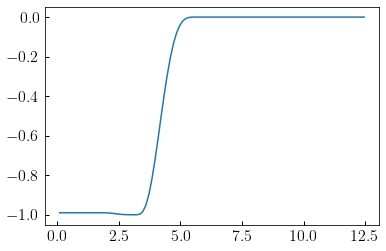

In [248]:
plt.plot(tarr, _quenching_kern(lgt, *q_params))

80

In [250]:
q_params

array([ 0.5 , -0.5 , -1.  , -0.99])